
### Sliding Mode Control
![alt text](SMC_image.png)

We have an UAV that we wish to design a GN&C system in which it starts to follow a path. The setting o fthe dynamics is shown above and the following parameters will describe the system mathematically:
- Lateral acceleration $a_m$
-  Heading angle (of the UAV) $\psi$
- Speed/velocity $v$
- Corrdinate velocity components $\dot{x} v cos(\psi) ,\; \dot{y} = v sin(\psi)$
- Heading angular velocity $\dot{\psi} = \frac{a_m}{v}$

From this, the idea is to use $a_m$ as a control input so that the UAV is steered towards and follows the desired path.

This will be deone according to [Kumar et. al.](https://www.sciencedirect.com/science/article/pii/S240589632300294X), where the guidance design takes the shape of an outer feedback loop involving a sliding mode controller, compensated by an inner sliding mode control loop that models the defects of having a system lag, due to physical properties of the UAV, like air viscosity, actuators etc.
![alt text](GNC_loop.png)
We will start out by designing the Guiance system, that aims to guide the UAV to the path.

### Guidance Subsystem

To get the UAV to steer towards the path, we design a dynamic system with regards to $d$, the perpendicular distance to the path. The idea is that a suitable lateral acceleration $a_m$ derived as a control input to a sliding mode controller will nullify $d$.

We can describe the rate of change in $d$ dynamically as $$\dot{d} = v sin(\psi - \psi_d) \Rightarrow \ddot{d} = v\dot{\psi} cos(\psi - \psi_d) - \dot{\psi}_s v cos(\psi-\psi_d)$$ 

Remembering that $\dot{\psi} = \frac{a_m}{v}$, we get that 

$$\ddot{d} = a_m cos(\psi - \psi_d) + \Delta \tag{1},$$ 
where we've assumed to lack enough path curvature information to describe the other term as anything else but a bounded uncertainty,
$$\Delta = -\dot{\psi}_d vcos(\psi-\psi_d), \;\; |\Delta| \le \Delta_{max} < \infty$$
Now at the outer loop, we from now on use the notation $a_m^c$ and use sliding mode control based on $(1)$ to drive the state $x = (d, \dot{d})$ towards the sliding surface 
$$S_d = d + \frac{1}{\beta_d} \dot{d}^{\frac{p_d}{q_d}},$$
where $\beta_d > 0$ and $1 < \frac{p_d}{q_d} < 2$.

Time derivation yields
$$\dot{S}_d = \dot{d} + \frac{1}{\beta_d}\frac{p_d}{q_d}\dot{d}^{\frac{p_d}{q_d}-1}\ddot{d} = \{ (1) \} = \dot{d} + \frac{1}{\beta_d}\frac{p_d}{q_d}\dot{d}^{\frac{p_d}{q_d}-1}\cdot \left(a_m^c cos(\psi-\psi_d) + \Delta\right)$$

Now, from the Lyapunov candidate $\mathcal{V} = \frac{1}{2}S_d^2$, we arrive at the condition $\dot{\mathcal{V}} = S_d \dot(S_d) < 0 \;\; \forall S \neq 0$, which after some math yields
$$a_m^c = \frac{1}{cos(\psi-\psi_d)}\left[\beta_d \frac{p_d}{q_d} \dot{d}^{2-\frac{p_d}{q_d}} + \eta sign(S_d)\right]$$
which by the way also manages to show that $\dot{d} = 0$ is not an attraction point (look in the [article](https://www.sciencedirect.com/science/article/pii/S240589632300294X)).

In [84]:
include("GuidanceDesign.jl")

simulate! (generic function with 6 methods)

### Define the parameters

In [85]:
GP = GuidanceParams(1.0, S_d(1.0, 15, 13, 30.0))

GuidanceParams(1.0, S_d(1.0, 15, 13, 30.0))

In [96]:
include("path_creator.jl")

plot_path_dist (generic function with 2 methods)

In [87]:
p₁ = (10, 10)
p₂ = (155, 155)

(155, 155)

In [88]:
path = straight_line_path([p₁, p₂]);
size(path[:, 2])


(1000,)

In [90]:
SP = SimParams(GP, 10)

SimParams(GuidanceParams(1.0, S_d(1.0, 15, 13, 30.0)), 10.0)

### Define the initial state
Let the UAV be in an initial state and set a time for which we wish to ismulate the response
### OBS - straight line case:
In this case, we shall follow a straight line. Thus, we just let $\psi_d = \arctan{\Delta p^2, \Delta p^1}$

In [91]:
init_pos1 = [10, 20];
init_pos2 = [10, 0];
psi = 0.1;

x_dot_init = [SP.v * cos(psi), SP.v * sin(psi)]

SP = SimParams(GP, 10)
psi_d = atan((p₂[2]-p₁[2])/(p₂[1]-p₁[1]));

### Simulate the response
Having given the initial conditions, we simulate the response and obtain the result

In [92]:
X1, Y1 = simulate!(SP, psi, psi_d, init_pos1)
X2, Y2 = simulate!(SP, psi, psi_d, init_pos2)

([10.0, 10.099500416527803, 10.19863509714181, 10.29731372171963, 10.395450133301866, 10.492961639873364, 10.589768433766034, 10.685793101651438, 10.780960204990542, 10.87519591565188  …  144.64044635053733, 144.71208689157388, 144.78161725589064, 144.85329001729122, 144.92285400145138, 144.99455894600422, 145.06415650917592, 145.13589359567328, 145.20552469294887, 145.2772938762238], [0.0, 0.009983341664682815, 0.02311022627447505, 0.03931297454227688, 0.05852871605183041, 0.08069865259113046, 0.10576745105101308, 0.13368273642476547, 0.16439466313157147, 0.1978555482984738  …  144.70326443935355, 144.77303286258348, 144.84490447337646, 144.91463979637146, 144.9864788672714, 145.05618109769964, 145.12798763779566, 145.19765678750247, 145.2694308099075, 145.33906689489257])

### Result
Below, we plot the response of the system and make sure that it follows the desired path

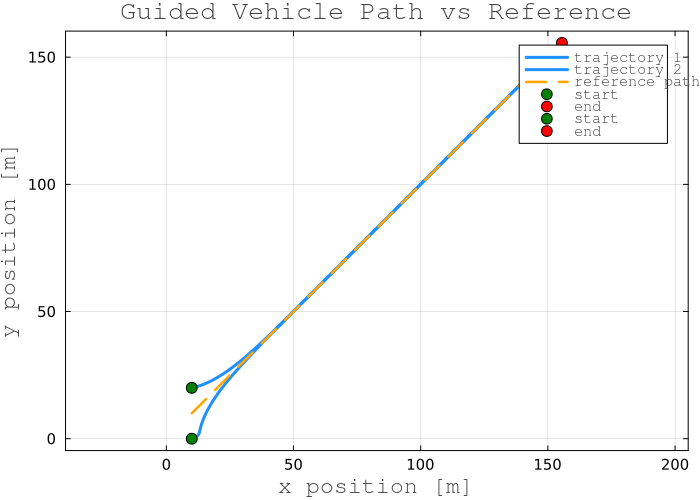

In [93]:
using Plots

plot(X1, Y1;
    label = "trajectory 1",
    xlabel = "x position [m]",
    ylabel = "y position [m]",
    title = "Guided Vehicle Path vs Reference",
    lw = 3,
    color = :dodgerblue,
    legend = :topright,
    grid = true,
    framestyle = :box,
    aspect_ratio = :equal,
    size = (700, 500),
    fontfamily = "sans",
    tickfont = font(10),
    guidefont = font(12, "Arial"),
    titlefont = font(14, "Arial Bold")
)
plot!(X2, Y2;
    label = "trajectory 2",
    xlabel = "x position [m]",
    ylabel = "y position [m]",
    title = "Guided Vehicle Path vs Reference",
    lw = 3,
    color = :dodgerblue,
    legend = :topright,
    grid = true,
    framestyle = :box,
    aspect_ratio = :equal,
    size = (700, 500),
    fontfamily = "sans",
    tickfont = font(10),
    guidefont = font(12, "Arial"),
    titlefont = font(14, "Arial Bold")
)

plot!(path[:, 1], path[:, 2];
    label = "reference path",
    lw = 2.5,
    linestyle = :dash,
    color = :orange,
)

# Mark start and end points
scatter!([X1[1]], [Y1[1]];
    label = "start",
    color = :green,
    markersize = 6,
)
scatter!([X1[end]], [Y1[end]];
    label = "end",
    color = :red,
    markersize = 6,
)

scatter!([X2[1]], [Y2[1]];
    label = "start",
    color = :green,
    markersize = 6,
)
scatter!([X2[end]], [Y2[end]];
    label = "end",
    color = :red,
    markersize = 6,
)

# Ensure axes fit tightly around data
# xlims!(minimum([X1; path[:, 1]]) - 5, maximum([X1; path[:, 1]]) + 5)
# ylims!(minimum([Y1; path[:, 2]]) - 5, maximum([Y1; path[:, 2]]) + 5)

display(current())


### Success 
The above plot approves that the path is followed by the UAV

### Circular Path
Having reached success with the straight line path, the UAV now follows a circular path

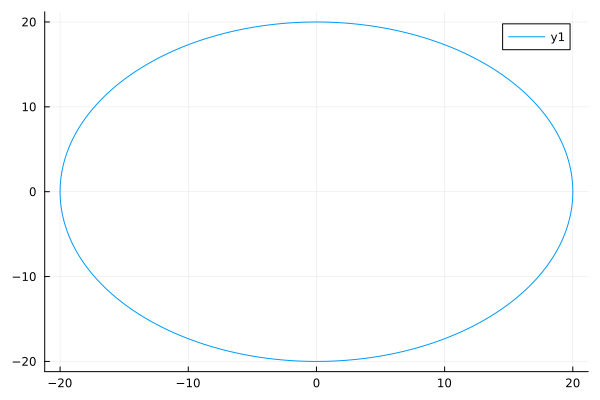

In [ ]:
c = [0, 0];
R = 20;

path = circular_path(c, R);
println(path)

In [95]:
init_pos1 = [-20, 10];
init_pos2 = [-20, 25];

x_dot_init = [SP.v * cos(psi), SP.v * sin(psi)]

SP = SimParams(GP, 10)

SimParams(GuidanceParams(1.0, S_d(1.0, 15, 13, 30.0)), 10.0)

Calculate the closest point on the path to the UAV, q

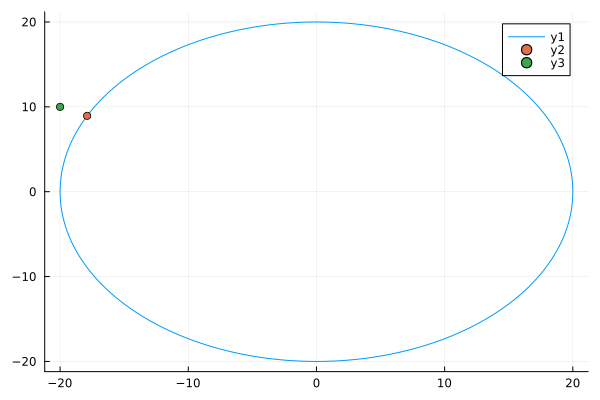

In [106]:
using LinearAlgebra
n = normalize(init_pos1 - c);
q = c + R*n;
plot(path[1], path[2])
scatter!([q[1]], [q[2]])
scatter!([init_pos1[1]], [init_pos1[2]])